In [1]:
import os
import pandas as pd

base_dir = 'dataset/flowers-recognition_configed'
input_data_dir = {'test':None, 'train':None, 'validation':None}

totalcounter = 0
dfs = {'train':None, 'validation':None, 'test':None}
for i in input_data_dir:
    print(i)
    classes_names = os.listdir(os.path.join(base_dir, i))
    input_data_dir[i] = os.path.join(base_dir, i)
    classes = {}
    for s in classes_names:
        classes[s] = len(os.listdir(os.path.join(base_dir, i, s)))
        
    inputdata = {'flower':None, 'count':None}
    inputdata['flower'] = [f for f, c in classes.items()]
    inputdata['count'] = [c for f, c in classes.items()]
    
    dfs[i] = pd.DataFrame(inputdata)
    totalcounter += dfs[i]['count'].sum()
    print('\t', 'image count mean:', int(dfs[i]['count'].mean()))
    print('\t', 'image count :', int(dfs[i]['count'].sum()))
print('-'.join(['' for i in range(0, 16)]))
print('total image count:', totalcounter)    

class_count = len(classes)

test
	 image count mean: 183
	 image count : 915
train
	 image count mean: 368
	 image count : 1840
validation
	 image count mean: 181
	 image count : 905
---------------
total image count: 3660


In [2]:
dfs['test']

,flower,count
0,daisy,183
1,dandelion,183
2,rose,183
3,sunflower,183
4,tulip,183


In [3]:
dfs['train']

,flower,count
0,daisy,368
1,dandelion,368
2,rose,368
3,sunflower,368
4,tulip,368


In [4]:
dfs['validation']

,flower,count
0,daisy,181
1,dandelion,181
2,rose,181
3,sunflower,181
4,tulip,181


# hyper parameters

In [6]:
from keras import optimizers
import math

h_params = {}

# image
h_params['image_size'] = 150 # defult 150
h_params['batch_size'] = 20 # defult 20

# fit
h_params['epochs'] = 100
h_params['steps_per_epoch'] = math.ceil(dfs['train']['count'].sum()/h_params['batch_size']) # defult 100
h_params['validation_steps'] = math.ceil(dfs['validation']['count'].sum()/h_params['batch_size']) # defult 50

# compile
h_params['learning_rate'] = 1e-3 # defult 1e-4
h_params['optimizer'] = optimizers.RMSprop(lr=h_params['learning_rate']) #optimizers.Adam(lr=h_params['learning_rate'])
h_params['metrics'] = ['acc']

# model architect

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(h_params['image_size'], h_params['image_size'], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(class_count, activation='softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
___________________________

In [8]:
model.compile(loss='categorical_crossentropy',
                optimizer=h_params['optimizer'],
                metrics=h_params['metrics'])

# preprocessing

In [9]:
train_dir = input_data_dir['train']
validation_dir = input_data_dir['validation']

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(h_params['image_size'], h_params['image_size']),
                                                    batch_size=h_params['batch_size'],
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(h_params['image_size'], h_params['image_size']),
                                                        batch_size=h_params['batch_size'],
                                                        class_mode='categorical')

Found 1840 images belonging to 5 classes.
Found 905 images belonging to 5 classes.


# train

In [10]:
import tensorflow as tf
import time

startt = time.time()

with tf.device('/GPU:0'):
    history = model.fit_generator(train_generator,
                              steps_per_epoch=h_params['steps_per_epoch'],
                              epochs=h_params['epochs'],
                              validation_data=validation_generator,
                              validation_steps=h_params['validation_steps'])

# save model
import helper as hlp
model_h = {}
model_h['history'] = history
model_h['train_duration'] = round(time.time() - startt)
model_h['hyper_parameters'] = h_params
model_h['hyper_parameters']['optimizer'] = str(h_params['optimizer'])
filename = str(round(time.time()))
filename = '_'.join([filename[:5], filename[5:6], filename[6:7], filename[7:8], filename[8:], 'augmentation'])
hlp.save(model_h, 'models/'+filename)

92/92 [==============================] - 15s 160ms/step - loss: 1.4686 - acc: 0.3435 - val_loss: 1.2369 - val_acc: 0.4718
Epoch 2/100
92/92 [==============================] - 11s 121ms/step - loss: 1.2432 - acc: 0.5082 - val_loss: 1.0985 - val_acc: 0.5669
Epoch 3/100
92/92 [==============================] - 11s 123ms/step - loss: 1.1211 - acc: 0.5549 - val_loss: 1.0200 - val_acc: 0.5768
Epoch 4/100
92/92 [==============================] - 11s 120ms/step - loss: 1.0654 - acc: 0.5712 - val_loss: 1.0309 - val_acc: 0.5779
Epoch 5/100
92/92 [==============================] - 11s 125ms/step - loss: 1.0332 - acc: 0.5924 - val_loss: 0.8785 - val_acc: 0.6475
Epoch 6/100
92/92 [==============================] - 11s 120ms/step - loss: 1.0017 - acc: 0.6120 - val_loss: 0.8551 - val_acc: 0.6519
Epoch 7/100
92/92 [==============================] - 11s 121ms/step - loss: 0.9382 - acc: 0.6310 - val_loss: 0.9189 - val_acc: 0.6331
Epoch 8/100
92/92 [==============================] - 11s 121ms/step - loss

model file name is: 15781_2_9_4_10_augmentation


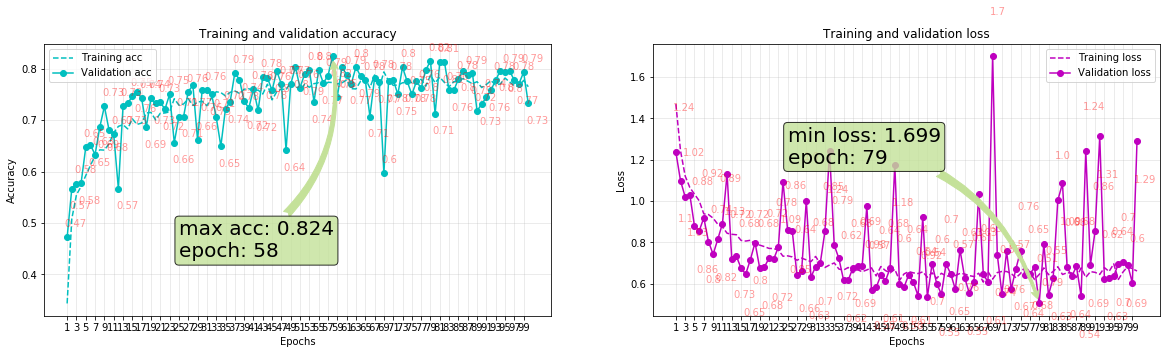

In [12]:
# show result with plot
print('model file name is:', filename)
hlp.show_model_plot(model_h);